In [1]:
import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

## Load up helper objects

files = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/")
st_id_map = pd.read_csv("/projects/my-public-bucket/fire_weather_vis/ref_data/isd-history.csv") ## For mappting ID's to lat lon

# Helper Variable
stations = fv.st_avail(files, st_id_map = st_id_map,  path_s3 = "veda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/")
st_dict = stations[['Lat', 'Lon']].to_dict('records')
#stations
#files

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/


In [2]:
fireID = '5119' ## Beachie -- but beach's closest station on wrong side of mountain!!! trying river
#fireID = '6590' # Riverside Fire
#fireID = '6610' # Holiday Farm
gdf = fv.load_large_fire(fireID, year = "2020", path_region="WesternUS")
#gdf['timediff'] = gdf.t.astype("datetime64[ns]") - pd.to_datetime("2021-08-14 18:00:00")
#gdf['timediff'] = gdf.timediff.astype("int")
#gdf["t"] = gdf["t"].astype("str")
gdf.t.astype("datetime64[ns]")
gdf = gdf.sort_values(by = ["t"])


/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:427: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


In [3]:
#gdf = gdf[gdf.t.dt.hour > 2] ### Only daytime hours
gdf = gdf[gdf.t.dt.hour > 0]

gdf["fline_diff"] = gdf.flinelen.diff() ## Add flireline difference for analysis later
gdf["farea_diff"] = gdf.farea.diff()
gdf["farea_second_diff"] = gdf.farea_diff.diff()


if(fireID == '5119'):
    foi = {"Lat" : 44.905,  "Lon": -123.001} ## The lat lon of Salem station
    full_fr = fv.merge_with_fire(gdf, st_dict, stations, foi_custom= foi ) 
else:
    full_fr = fv.merge_with_fire(gdf, st_dict, stations ) 


44.905
-123.001
The closest station is 0.0 km away.
The closest station is 0.0 km away.


/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:127: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)


In [4]:
time_of_interest = 24
hours_before = 0

max_spread = max(full_fr.fline_diff[full_fr.fline_diff.notna()])
print(max_spread)
print(max_spread *0.15)

104.52754627941412
15.679131941912118


In [5]:
daytime = ['7','8','9','10','11','12','13','14','15','16','17','18'] # My def of daytime



full_fr["is_daytime"] = full_fr.HH.isin(daytime)
full_fr["flinlen_day"] = full_fr.flinelen

# mask = np.invert(full_fr.is_daytime)
# full_fr.flinlen_day.loc[mask] = np.nan
# #full_fr["flinlen_day_diff"] = 
# #full_fr.is_daytime.unique()

### Fire area differnce
full_fr["spread_line"] = ((full_fr["farea_diff"] > 0) & (full_fr["farea_diff"] > (max_spread * 0.50)))
#full_fr["spread_line"] = ((full_fr["fline_diff"] > 0)) #& (full_fr["fline_diff"] > (max_spread * 0.15)))

#full_fr["t_lag"] = full_fr["t"] - np.timedelta64(time_lag, 'h')
times = full_fr["t"].loc[full_fr["spread_line"] ]
times_not = full_fr["t"].loc[full_fr["spread_line"] == False]
times_not = times_not[(times_not.dt.hour == 13) & (times_not.dt.minute == 30)]
#print("TIMES:", times)
#print("TIMES_NOT:", times_not)
#times_start = times - np.timedelta64(time_lag, "h")

full_fr["sumFRP"] = full_fr.meanFRP * full_fr.n_newpixels

full_fr["flinlen_day"] = full_fr.flinelen

mask = np.invert(full_fr.is_daytime)
full_fr.flinlen_day.loc[mask] = np.nan
#full_fr["flinlen_day_diff"] = 
#full_fr.is_daytime.unique()

/tmp/ipykernel_405/3110483731.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr.flinlen_day.loc[mask] = np.nan


In [6]:
full_fr["spread_day"] = np.nan
for t in times:
    times_start = t - np.timedelta64((time_of_interest + hours_before), "h")
    times_end = t - np.timedelta64((hours_before), "h")
    full_fr.spread_day[(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True
    

for l in times_not:
    times_start = l - np.timedelta64((time_of_interest + hours_before), "h")
    times_end = l - np.timedelta64((hours_before), "h")
    full_fr.spread_day[(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = False
    
# full_fr["spread_day"] = False
# for t in times:
#     times_start = t - np.timedelta64((time_of_interest + hours_before), "h")
#     times_end = t - np.timedelta64((hours_before), "h")
#     full_fr.spread_day[(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True
full_fr["spread_day"]

/tmp/ipykernel_405/3674384972.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr.spread_day[(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True


0       NaN
74      NaN
75      NaN
76      NaN
77      NaN
       ... 
1749    NaN
1750    NaN
1751    NaN
1752    NaN
73      NaN
Name: spread_day, Length: 1753, dtype: object

<AxesSubplot: xlabel='t', ylabel='farea'>

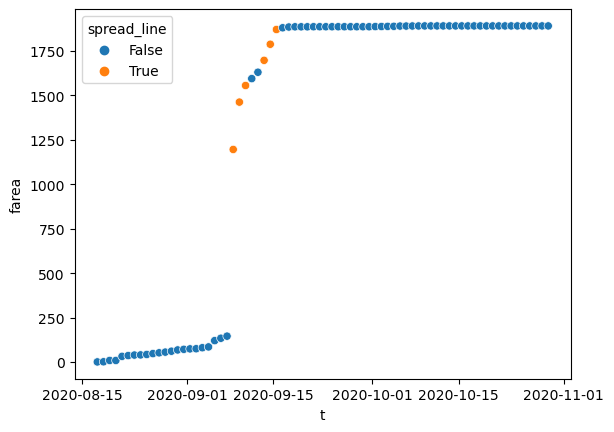

In [7]:
full_fr = full_fr.sort_values(by = ['t']) ## Need to sort or timeseries jumps around
full_fr['t'] = full_fr['t'].astype('datetime64[ns]')


import seaborn as sns
sns.scatterplot(x = full_fr.t, y =full_fr.farea, hue =  full_fr.spread_line)

1890.3260834976406
55.88235294117647
0          0
1          1
2          2
3          3
4          4
        ... 
1748    1748
1749    1749
1750    1750
1751    1751
1752    1752
Length: 1753, dtype: int64


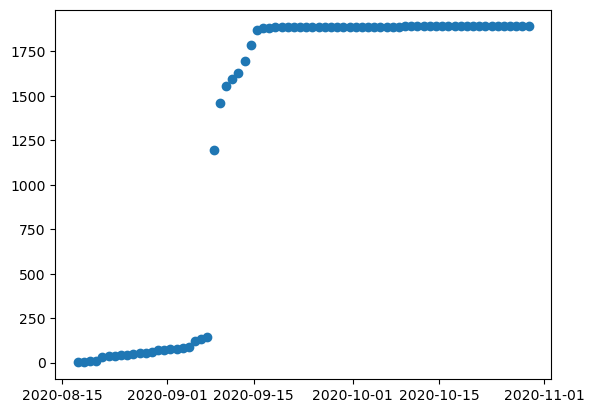

In [8]:
print(max(full_fr.farea)) # 1002 is asymptote

delta_area = 950/17 # (I eyeballed this)
print(delta_area)

plt.scatter(x = full_fr.t, y =full_fr.farea)
series = pd.Series(range(0, len(full_fr.t)))
print(series)
#plt.plot(full_fr.t, ((1002*series) - 1008)/(series + 52)) ## An exponential function Not a great fit honestly. Need something sigmoidal?
#plt.plot(full_fr.t, (1/(1 + np.exp(-series))) * 1002) # Logistic not great either
#plt.plot(full_fr.t, (series/(1 + np.abs(series))) * 1002)

<AxesSubplot: xlabel='t', ylabel='farea_diff'>

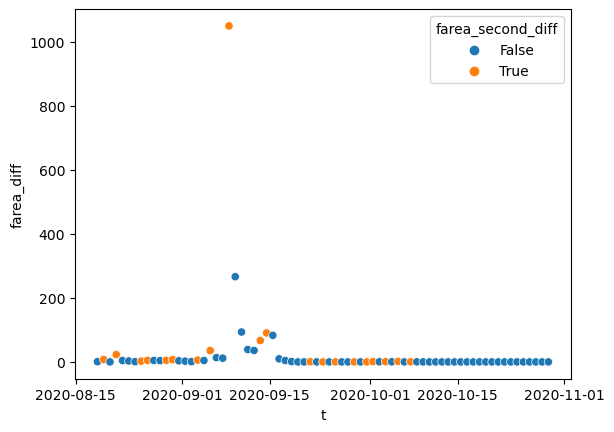

In [9]:
sns.scatterplot(x = full_fr.t, y = full_fr.farea_diff, hue = full_fr.farea_second_diff > 0)

[            nan  5.38600740e-01  8.39189877e-01  0.00000000e+00
  7.20585693e-01  1.19762165e-01  7.60757645e-02  1.94909285e-02
  5.82289914e-02  1.02439297e-01  8.56673930e-02  7.11541486e-02
  8.35986231e-02  1.03689516e-01  4.88987789e-02  3.38830082e-02
  1.04979774e-02  7.03702308e-02  5.34618146e-02  2.94164777e-01
  1.00077180e-01  8.06404093e-02  8.78198123e-01  1.82178197e-01
  6.00523662e-02  2.43064267e-02  2.19758142e-02  3.93947249e-02
  5.06491463e-02  4.44209772e-02  5.09559328e-03  2.29444221e-03
  6.06904609e-04  4.82402824e-16 -1.92961130e-15  2.13455388e-04
 -2.65264919e-15  8.44024742e-16 -3.37609897e-15  1.56747452e-15
 -3.25552400e-15  6.39047304e-15  4.50613148e-04  2.20763125e-04
  3.82738827e-04  1.66377290e-04  8.29807042e-04 -2.40655869e-15
  1.67616623e-04  1.15604361e-04  9.20906621e-05]
1753


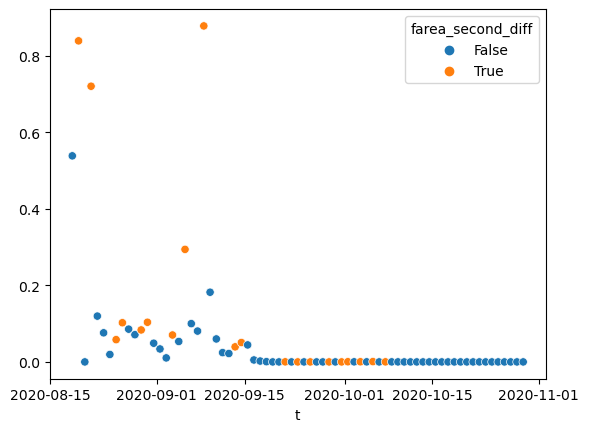

In [10]:
sns.scatterplot(x = full_fr.t, y = full_fr.farea_diff/full_fr.farea, hue = full_fr.farea_second_diff > 0)
area_corrected = full_fr.farea_diff/full_fr.farea
print(area_corrected.unique() )
print(len(series))

<AxesSubplot: xlabel='t', ylabel='farea_diff'>

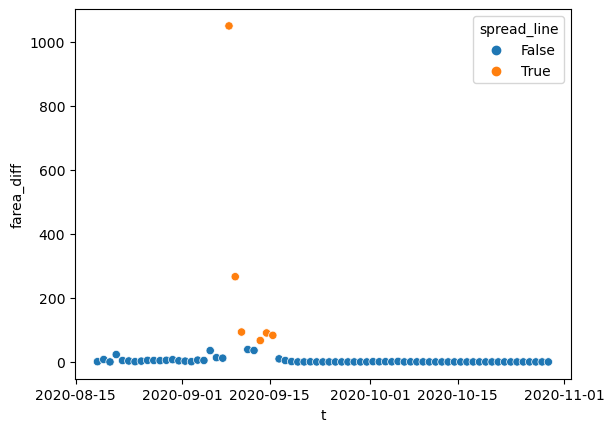

In [11]:
sns.scatterplot(x = full_fr.t, y = full_fr.farea_diff, hue = full_fr.spread_line)

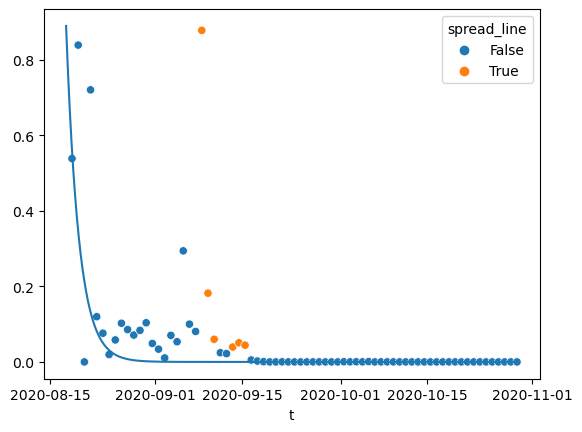

In [12]:
sns.scatterplot(x = full_fr.t, y = full_fr.farea_diff/full_fr.farea, hue = full_fr.spread_line)
series2 = [1.0, series[1:]]
series2 = pd.Series(series2)
#print(series2.unique)
plt.plot(full_fr.t.iloc[1:], 0.908*np.exp(-0.0201 * series.iloc[1:]))

<AxesSubplot: xlabel='t', ylabel='farea'>

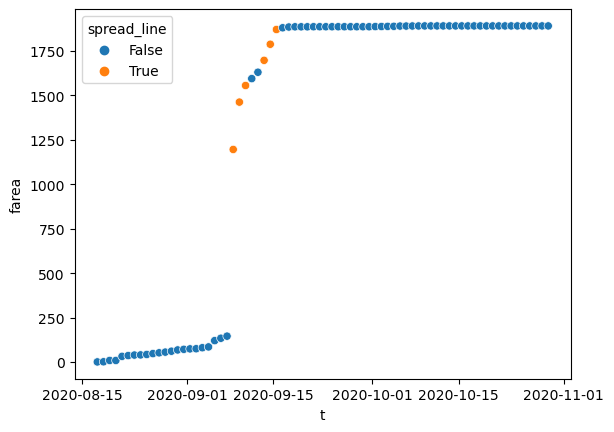

In [13]:
sns.scatterplot(x = full_fr.t, y = full_fr.farea, hue = full_fr.spread_line)

/tmp/ipykernel_405/341047964.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_corrected[diff_corrected < 1] = np.nan


<AxesSubplot: xlabel='t'>

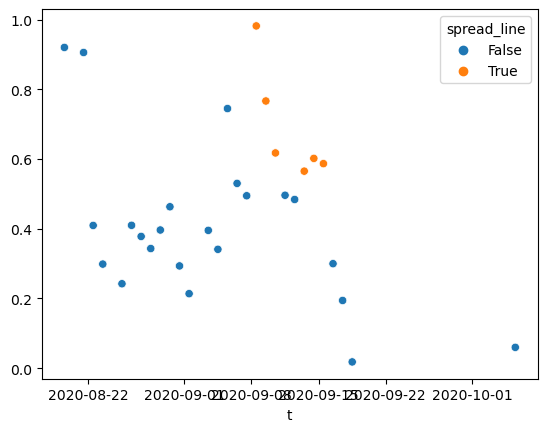

In [27]:

diff_corrected = full_fr.farea_diff
diff_corrected[diff_corrected < 1] = np.nan
farea_align = full_fr.farea.sort_index().iloc[0:(len(full_fr.farea) - 1)]
#tips['bill level'] = pd.cut(tips["total_bill"], [0, 30, 1000], labels=["≤ 30", "> 30"])
sns.scatterplot(x = full_fr.t, y = np.log(diff_corrected)/np.log(full_fr.farea), hue = full_fr.spread_line)

/tmp/ipykernel_405/3387278555.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_corrected[diff_corrected < 1] = np.nan


<AxesSubplot: xlabel='farea', ylabel='farea_diff'>

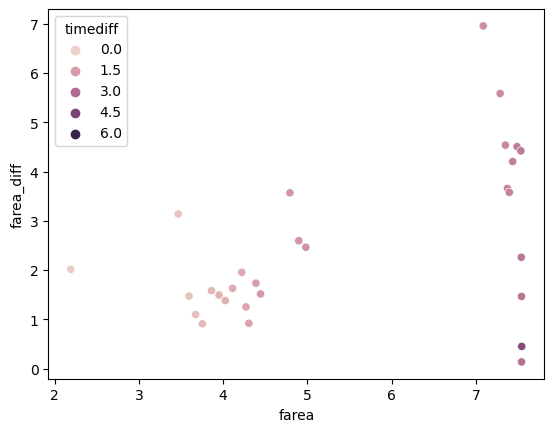

In [15]:
diff_corrected = full_fr.farea_diff
diff_corrected[diff_corrected < 1] = np.nan
sns.scatterplot(y = np.log(diff_corrected), x = np.log(full_fr.farea), hue = full_fr.timediff)

In [16]:
full_fr.columns

Index(['n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration',
       'pixden', 'meanFRP', 't', 'geometry', 'lon', 'lat', 'fline_diff',
       'farea_diff', 'farea_second_diff', 'fireID', 'Fire_Name', 'timediff',
       'YYYY', 'MM', 'DD', 'HH', 'TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'PREC_MM', 'SNOWD_M', 'FFMC', 'DMC', 'DC', 'BUI', 'ISI', 'FWI',
       'OBSMINUTEDIFFTEMP', 'OBSMINUTEDIFFRH', 'OBSMINUTEDIFFWDSPD',
       'OBSMINUTEDIFFPREC', 'OBSMINUTEDIFFSNOW', 'HH_format', 'is_daytime',
       'flinlen_day', 'spread_line', 'sumFRP', 'spread_day'],
      dtype='object')

<AxesSubplot: xlabel='farea_diff', ylabel='Count'>

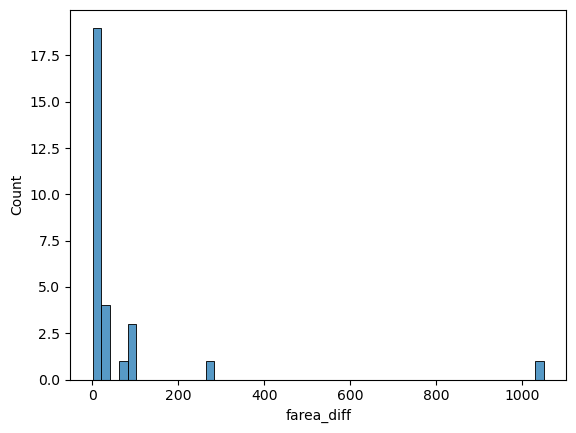

In [17]:
sns.histplot(full_fr.farea_diff)


<AxesSubplot: xlabel='t', ylabel='farea_second_diff'>

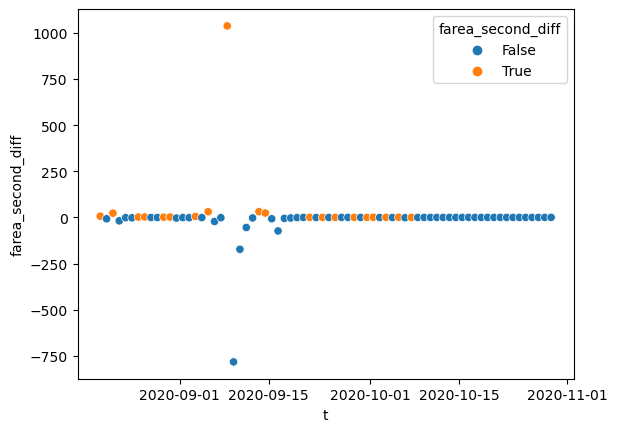

In [18]:
sns.scatterplot(x = full_fr.t, y = full_fr.farea_second_diff, hue = full_fr.farea_second_diff > 0)

<AxesSubplot: xlabel='t', ylabel='flinelen'>

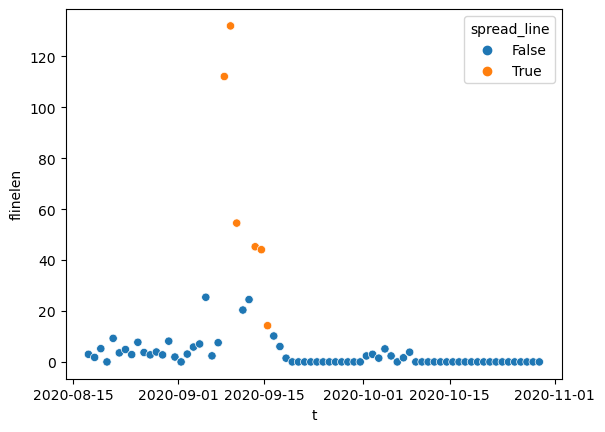

In [19]:
sns.scatterplot(x = full_fr.t, y = full_fr.flinelen, hue = full_fr.spread_line)

<AxesSubplot: xlabel='TEMP_C', ylabel='farea_diff'>

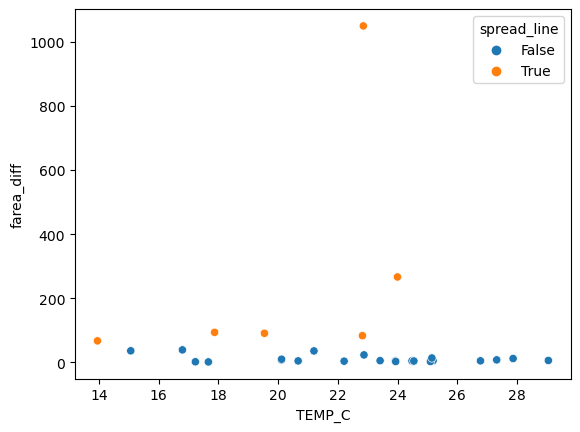

In [20]:
sns.scatterplot(x = full_fr.TEMP_C, y = full_fr.farea_diff, hue = full_fr.spread_line) # Oh shit that looks pretty good. 

In [21]:
full_fr.timediff.unique()

array([0.0000e+00,        nan, 8.6400e+13, 1.7280e+14, 2.5920e+14,
       3.4560e+14, 4.3200e+14, 5.1840e+14, 6.0480e+14, 6.9120e+14,
       7.7760e+14, 8.6400e+14, 9.5040e+14, 1.0368e+15, 1.1232e+15,
       1.2096e+15, 1.2960e+15, 1.3824e+15, 1.4688e+15, 1.5552e+15,
       1.6416e+15, 1.7280e+15, 1.8144e+15, 1.9008e+15, 1.9872e+15,
       2.0736e+15, 2.1600e+15, 2.2464e+15, 2.3328e+15, 2.4192e+15,
       2.5056e+15, 2.5920e+15, 2.6784e+15, 2.7648e+15, 2.8512e+15,
       2.9376e+15, 3.0240e+15, 3.1104e+15, 3.1968e+15, 3.2832e+15,
       3.3696e+15, 3.4560e+15, 3.5424e+15, 3.6288e+15, 3.7152e+15,
       3.8016e+15, 3.8880e+15, 3.9744e+15, 4.0608e+15, 4.1472e+15,
       4.2336e+15, 4.3200e+15, 4.4064e+15, 4.4928e+15, 4.5792e+15,
       4.6656e+15, 4.7520e+15, 4.8384e+15, 4.9248e+15, 5.0112e+15,
       5.0976e+15, 5.1840e+15, 5.2704e+15, 5.3568e+15, 5.4432e+15,
       5.5296e+15, 5.6160e+15, 5.7024e+15, 5.7888e+15, 5.8752e+15,
       5.9616e+15, 6.0480e+15, 6.1344e+15, 6.2208e+15, 6.3072e

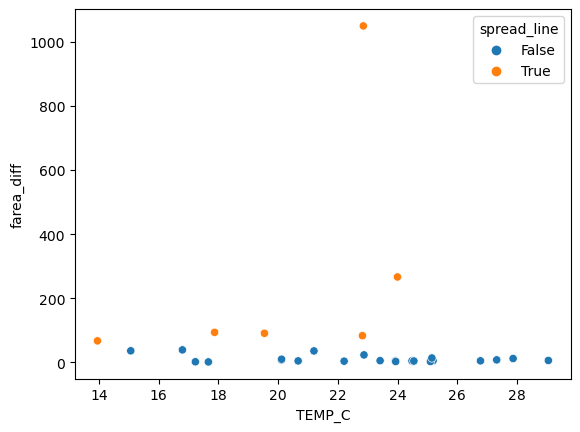

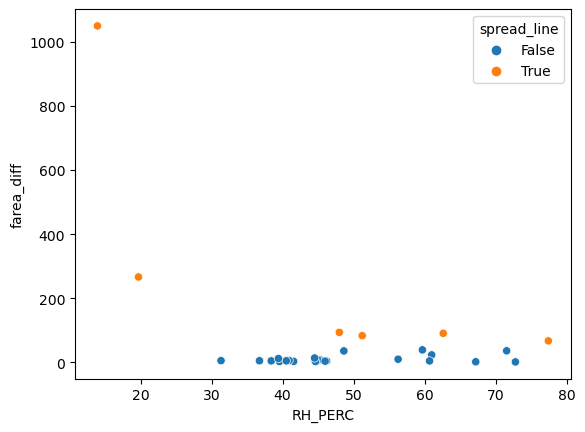

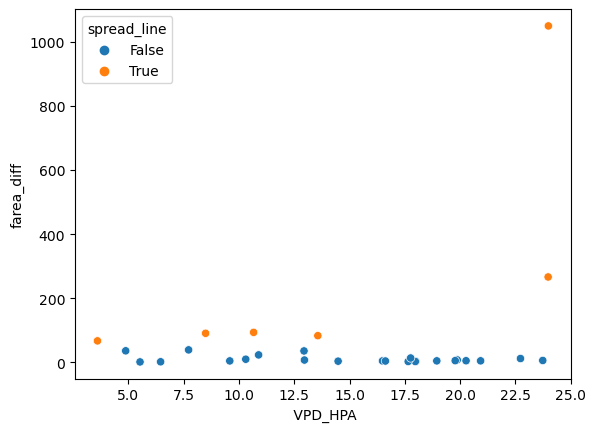

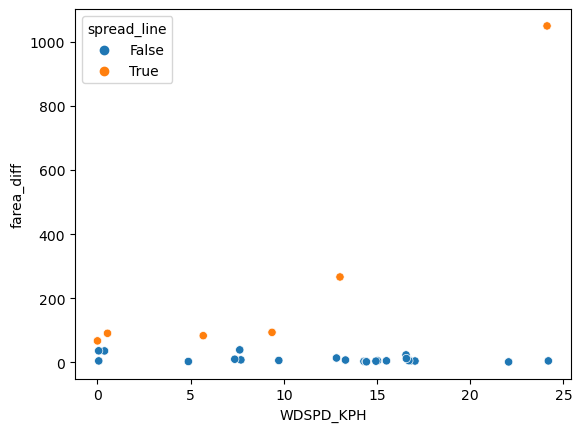

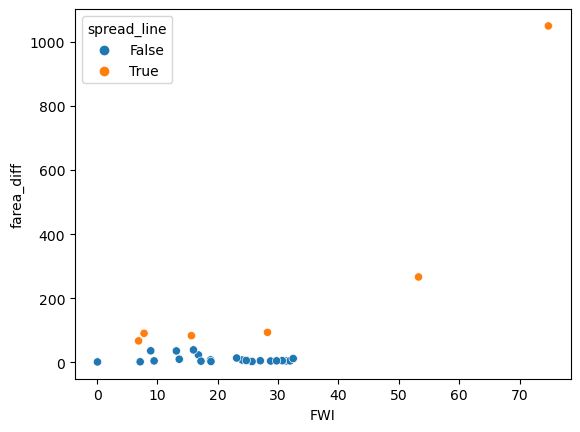

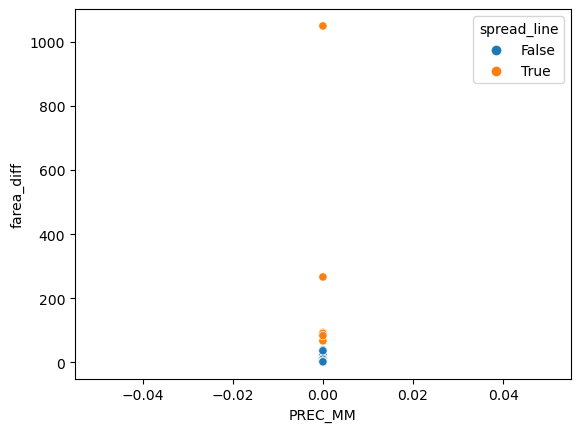

In [22]:
met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI', 'PREC_MM']

for m in met:
    plt.figure()
    sns.scatterplot(x = full_fr[m], y = full_fr.farea_diff, hue = full_fr.spread_line) ## The relationship between fire area anf temp seems time sensitive. (Which we would expect -- fire becomes more "self sustaining" later) ## Could this be autocorrelation? Need more fires. This might be just pitting out the logarithmic growth looking curve -- rh looks
    
    

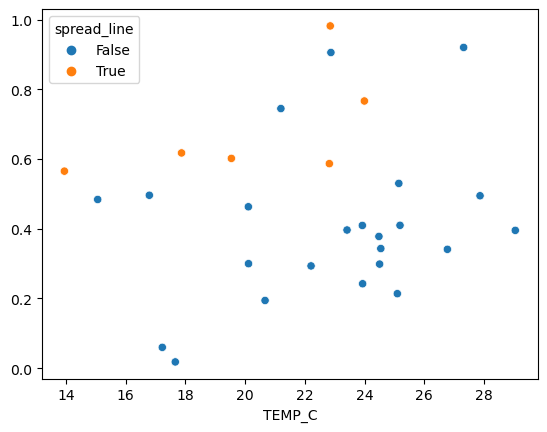

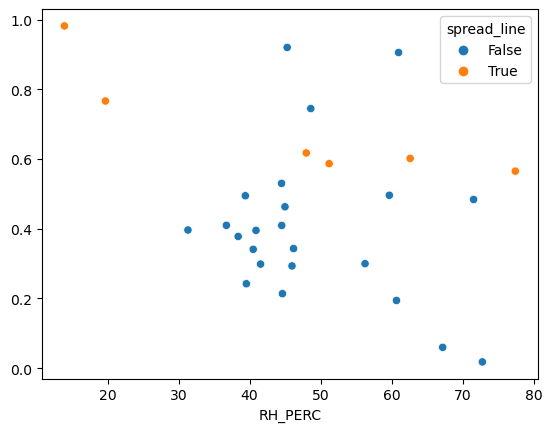

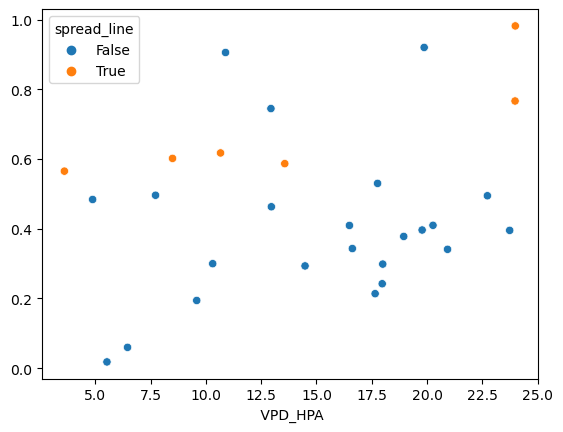

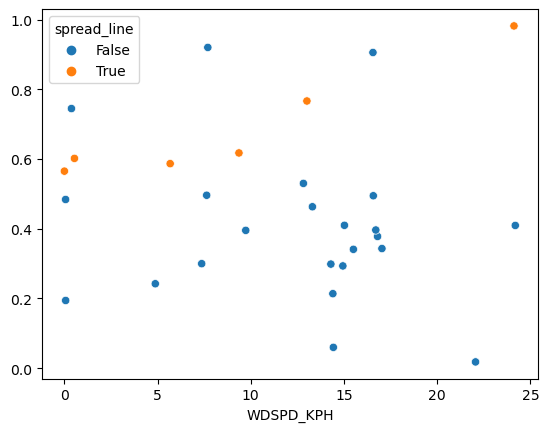

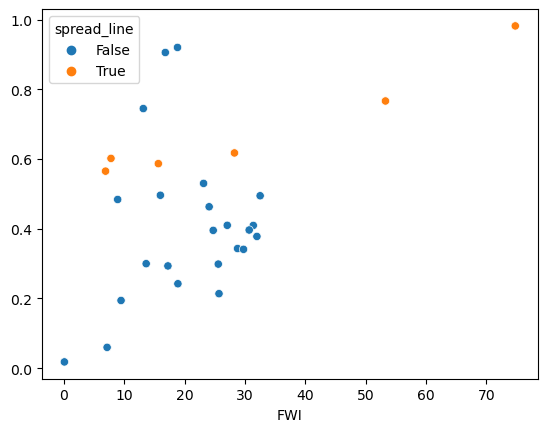

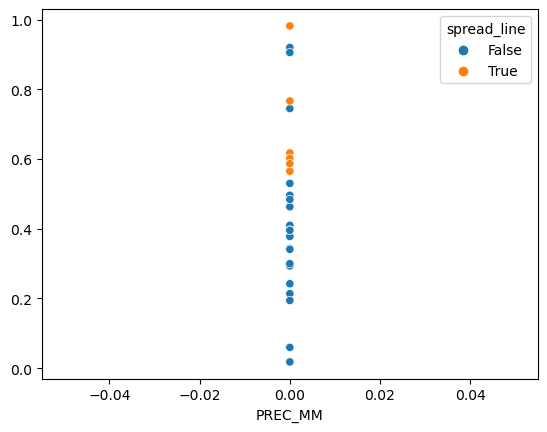

In [23]:
met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI', 'PREC_MM']

for m in met:
    plt.figure()
    sns.scatterplot(x = full_fr[m], y = np.log(diff_corrected)/np.log(full_fr.farea), hue = full_fr.spread_line)
    

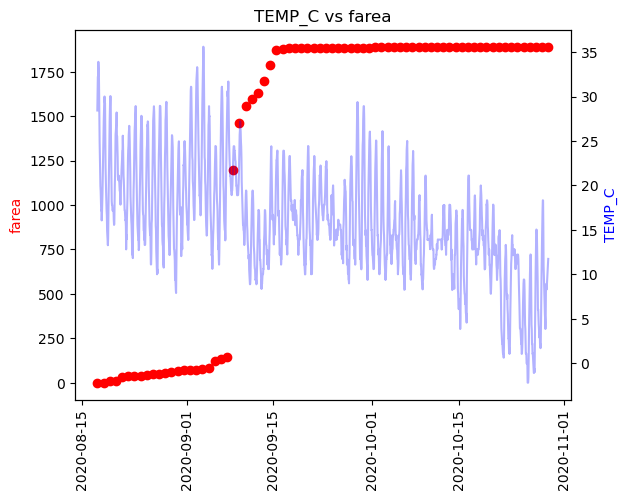

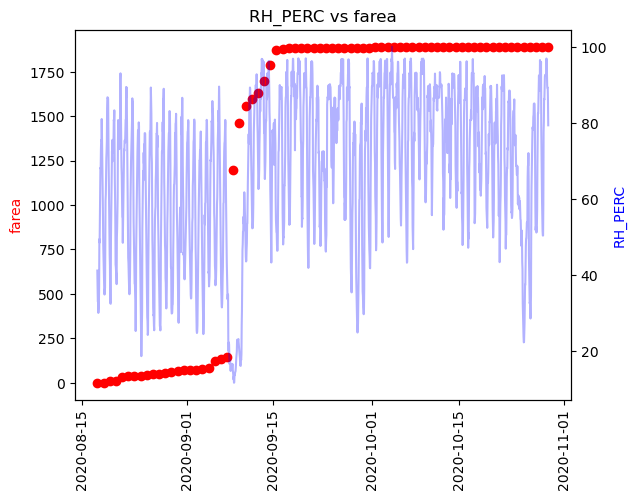

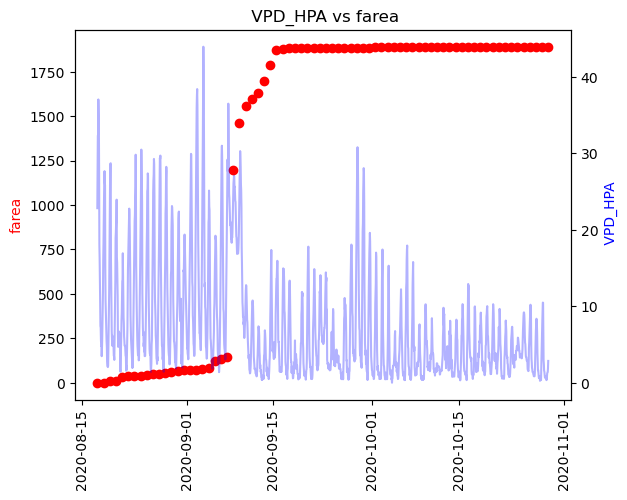

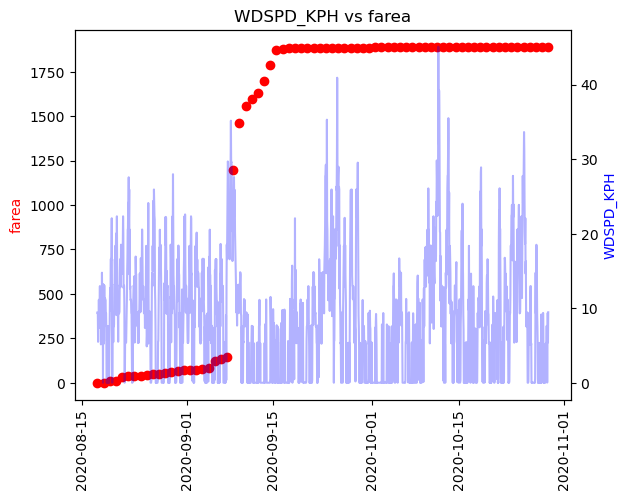

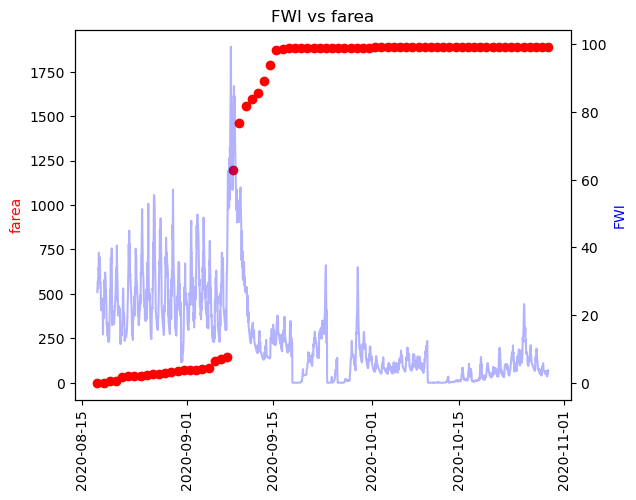

In [24]:
met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI']  ## Station Data Columns to Plot
fire = ["farea"] ## gdf columns to plot

#n_met = len(met)
#n_fire = len(fire)

for m in met:
    for f in fire:
        fig, ax = plt.subplots()
        
        ax.scatter(full_fr["t"], full_fr[f], color = "r")
        #ax.plot(full_fr["t"], full_fr[m])
        #plt.xticks(rotation = 90)   
        ax.set_title(m + " vs " +  f)
        ax.set_ylabel(f, color = "red")
        ax2=ax.twinx()
        ax2.plot(full_fr["t"], full_fr[m],color="blue",  alpha=0.3)
        ax2.set_ylabel(m,color="blue")
        ax.tick_params(axis='x', labelrotation = 90)

        plt.show()

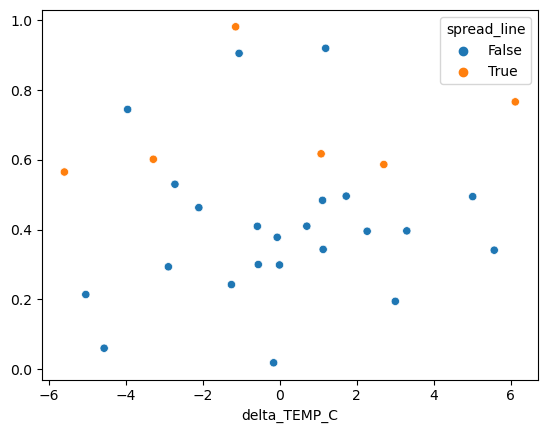

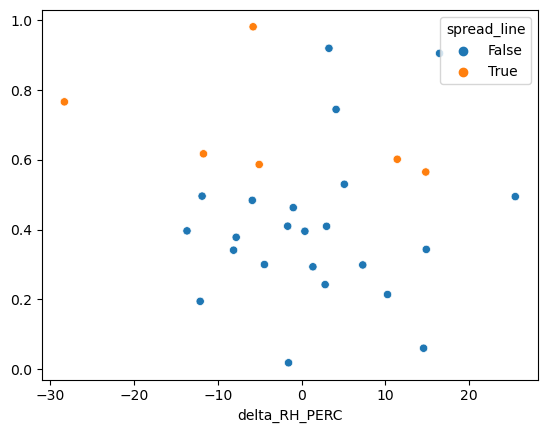

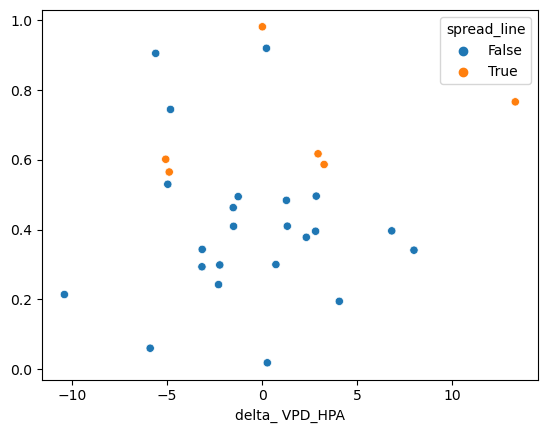

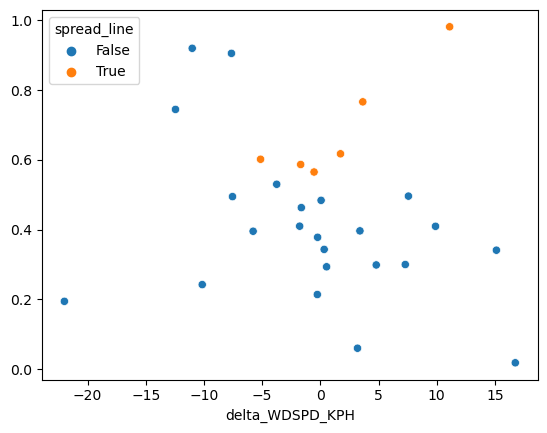

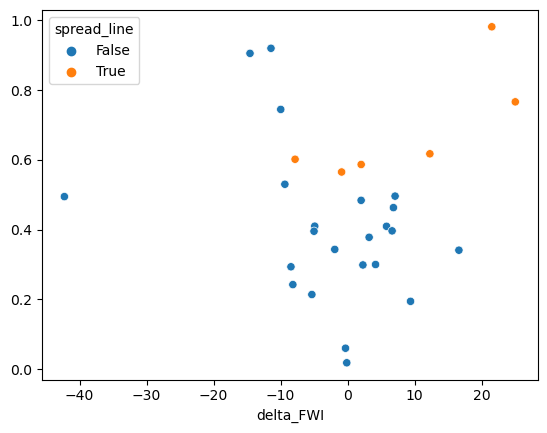

In [25]:
### Make a delta met set of variables

#delta_m = full_fr["TEMP_C"].diff(periods=1)

#plt.plot(full_fr.t, (full_fr.TEMP_C - np.mean(full_fr.TEMP_C)))
#plt.plot(full_fr.t, delta_m)

met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI']

for m in met:
    full_fr["delta_" + m] = full_fr[m].diff(-24)
    #full_fr["delta_" + m] = full_fr[m].pct_change(24)

met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI']

for m in met:
    plt.figure()
    sns.scatterplot(x = full_fr["delta_" + m], y = np.log(diff_corrected)/np.log(full_fr.farea), hue = full_fr.spread_line) ## Windspeed might be suffering from 0 observations? could need an average?  
    

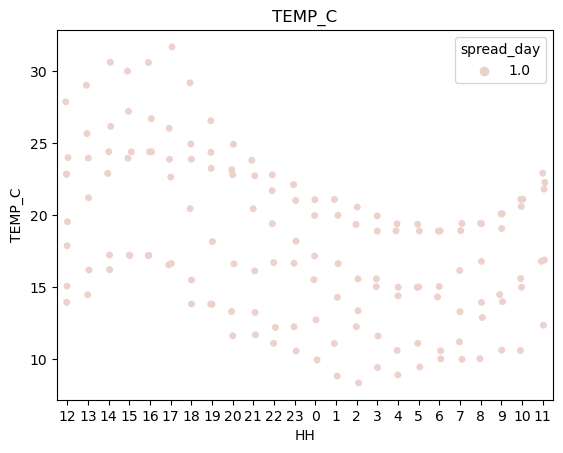

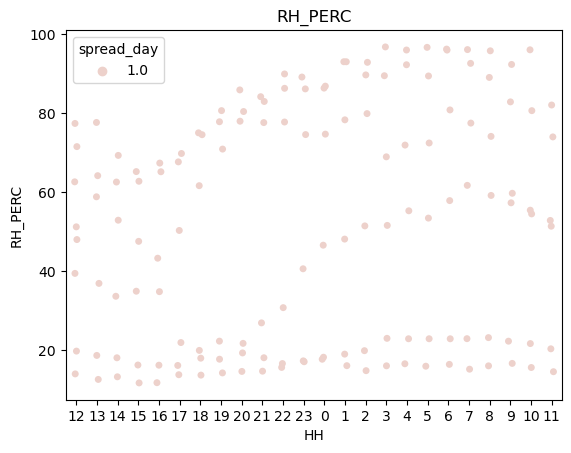

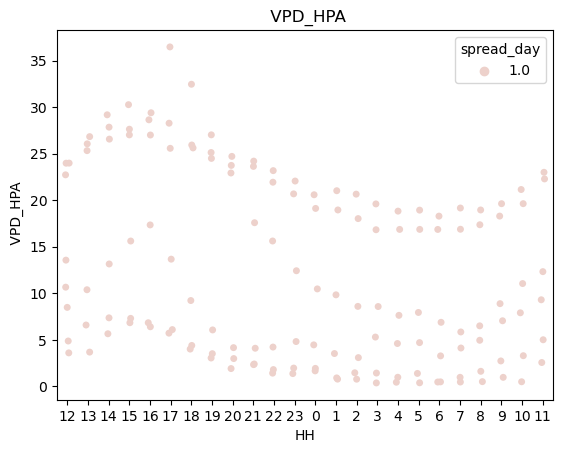

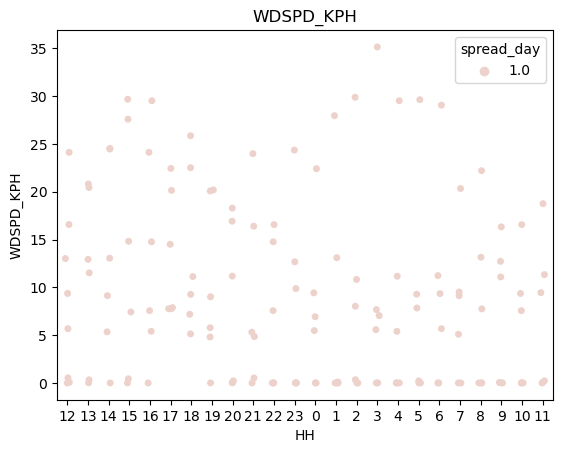

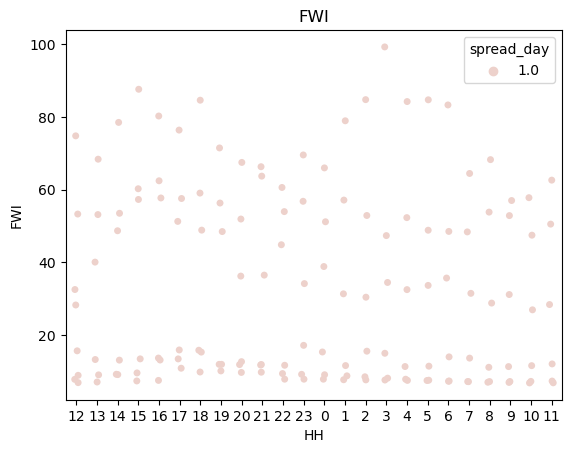

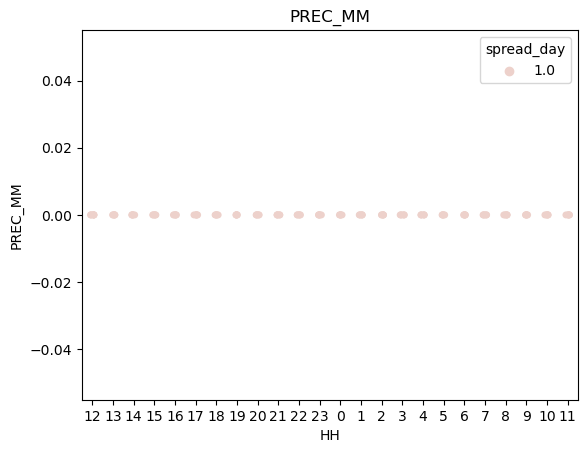

In [26]:
met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI', 'PREC_MM']


#for m in met:
#    plt.scatter(x = full_fr['HH'], y = full_fr[m], c = full_fr["spread_day"], s = 0.9)
#    plt.title(m)
#    plt.show()

    
# for m in met:
#    sns.violinplot(x = full_fr['HH'], y = full_fr[m], hue = full_fr["spread_day"])
#    plt.title(m)
#    plt.show()  
    
# for m in met:
#     sns.stripplot(x = full_fr['HH'], y = full_fr[m], hue = full_fr["is_daytime"], dodge = True)
#     plt.title(m)
#     plt.show()  

for m in met:
    sns.stripplot(x = full_fr['HH'], y = full_fr[m], hue = full_fr["spread_day"], dodge = True)
    plt.title(m)
    plt.show()

In [155]:
## Compare GOES data in diurnal framework



In [138]:
#?pd.merge